In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-krylov-minrescg)=
# MINRES and conjugate gradients

```{index} symmetric matrix
```

We have seen before that certain matrix properties enhance solutions to linear algebra problems. One of the most important of these is when $\mathbf{A}^*=\mathbf{A}$; i.e., $\mathbf{A}$ is hermitian. The Arnoldi iteration has a particularly useful specialization to this case. While in this section we describe the resulting algorithms, we do not present them in detail or show implementations.

## Lanczos iteration

Starting from {eq}`arnoldimat`, we left-multiply by $\mathbf{Q}_m^*$ to get

:::{math}
\mathbf{Q}_m^* \mathbf{A} \mathbf{Q}_m = \mathbf{Q}_m^* \mathbf{Q}_{m+1} \mathbf{H}_m = \tilde{\mathbf{H}}_m,
:::

where $\tilde{\mathbf{H}}_m$ is rows 1 through $m$ of $\mathbf{H}_m$. If $\mathbf{A}$ is hermitian, then so is the left side of this equation, hence $\tilde{\mathbf{H}}_m$ is hermitian too. But it is also upper Hessenberg, meaning that the $(i,j)$ element is zero if $i > j+1$. By symmetry, this means that elements are zero when $j > i+1$ as well.

::::{proof:observation}
For a hermitian (or real symmetric) matrix, the upper Hessenberg matrix $\mathbf{H}_m$ produced by the Arnoldi iteration is tridiagonal.
::::

```{index} Arnoldi iteration
```
Equation {eq}`arnoldivec` of the Arnoldi iteration now simplifies to a much shorter expression:

:::{math}
:label: lanczos
\mathbf{A} \mathbf{q}_m = H_{m-1,m} \,\mathbf{q}_{m-1} + H_{mm} \,\mathbf{q}_m + H_{m+1,m}\,\mathbf{q}_{m+1}.
:::

```{index} ! Lanczos iteration
```

As before in deriving the Arnoldi iteration, when given the first $m$ vectors we can solve for the entries in column $m$ of $\mathbf{H}$ and then for $\mathbf{q}_{m+1}$. The resulting process is known as the **Lanczos iteration**. Its most important practical advantage is that while Arnoldi needs $O(m)$ steps to get $\mathbf{q}_{m+1}$ from the previous vectors, Lanczos needs only $O(1)$ steps, so restarting isn't required for symmetric matrices.[^lanczos]

[^lanczos]: In principle, the implementation of Lanczos iteration is minor change from Arnoldi, but numerical stability requires some extra analysis and effort. We do not present the details.

## MINRES

```{index} GMRES; relationship to MINRES, ! MINRES
```

When $\mathbf{A}$ is hermitian and the Arnoldi iteration is reduced to Lanczos, the analog of GMRES is known as **MINRES**. Like GMRES, MINRES minimizes the residual $\|\mathbf{b}-\mathbf{A}\mathbf{x}\|$ over increasingly larger Krylov spaces.

MINRES is also more theoretically tractable than GMRES. The following result relies on some advanced approximation theory. Recall that the eigenvalues of a hermitian matrix are real. 

(theorem-minrescg-indefinite)=
::::{proof:theorem} Convergence of MINRES (indefinite case)
Suppose $\mathbf{A}$ is hermitian, invertible, and indefinite. Divide its eigenvalues into positive and negative sets $\Lambda_+$ and $\Lambda_-$, and define

$$
\kappa_+ = \frac{ \max_{\lambda \in \Lambda_+}  |\lambda| }{ \min_{\lambda \in \Lambda_+}  |\lambda| }, \qquad
\kappa_- = \frac{ \max_{\lambda \in \Lambda_-}  |\lambda| }{ \min_{\lambda \in \Lambda_-}  |\lambda| }.
$$

Then $\mathbf{x}_m$, the $m$th solution estimate of MINRES, satisfies

:::{math}
:label: minres-conv
\frac{\|\mathbf{r}_m\|_2}{\|\mathbf{b}\|_2} \le  \left( \frac{\sqrt{\kappa_+\kappa_-} - 1}{\sqrt{\kappa_+\kappa_-} + 1} \right)^{\lfloor m/2\rfloor},
:::

where $\lfloor m/2\rfloor$ means to round $m/2$ down to the nearest integer.
::::

```{index} convergence rate; linear
```

The bound for a definite matrix is better, as the next theorem shows. The upper bound {eq}`minres-conv` on the residual obeys a linear convergence rate. As the product $\kappa_+\kappa_-$ grows, the rate of this convergence approaches 1. Hence the presence of eigenvalues close to the origin (relative to the max eigenvalues) is expected to force a slower convergence. 

::::{proof:example}
Suppose $\mathbf{A}$ has $\kappa_+=60$ and $\kappa_-=15$. Then to achieve a guaranteed reduction in the relative residual of $10^{-3}$, we require

$$
\left( \frac{\sqrt{900} - 1}{\sqrt{900} + 1} \right)^{\lfloor m/2\rfloor} \le 10^{-3},
$$

$$
 {\lfloor m/2\rfloor} \log_{10} \left( \frac{29}{31} \right) \le -3,
$$

$$
 m  \ge  2 \lceil \frac{3}{\log_{10}(29/31)} \rceil = 208.
$$

Because the theorem gives an upper bound, MINRES may converge faster. All we can say is that 208 is certain to be enough iterations.
::::

(demo-minrescg-indefinite)=
:::{proof:demo}
:::

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The following matrix is indefinite.

In [2]:
A = FNC.poisson(10) - 20I
λ = eigvals(Matrix(A))
isneg = @. λ < 0
@show sum(isneg),sum(.!isneg);

(sum(isneg), sum(.!(isneg))) = (13, 87)


We can compute the relevant quantities from {numref}`Theorem {number} <theorem-minrescg-indefinite>`.

In [3]:
mn,mx = extrema(-λ[isneg])
κ₋ = mx/mn
mn,mx = extrema(λ[.!isneg])
κ₊ = mx/mn
ρ = (sqrt(κ₋*κ₊)-1) / (sqrt(κ₋*κ₊)+1)

0.9026418585584018

Because the iteration number $m$ is halved in {eq}`minres-conv`, the rate constant of linear convergence is the square root of this number, which makes it even closer to 1. 

Now we apply MINRES to a linear system with this matrix, and compare the observed convergence to the upper bound from the theorem.

```{index} ! Julia; minres
```

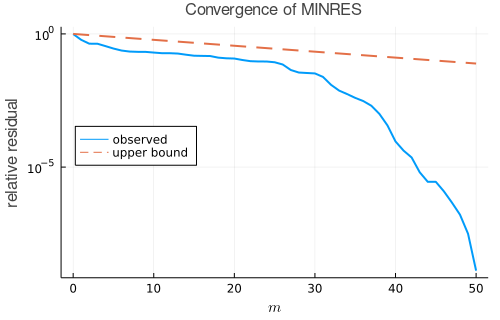

In [4]:
b = rand(100)
x,hist = minres(A,b,reltol=1e-10,maxiter=51,log=true);

relres = hist[:resnorm] / norm(b)
m = 0:length(relres)-1
plot(m,relres,label="observed",leg=:left,
	xaxis=L"m",yaxis=(:log10,"relative residual"),
	title=("Convergence of MINRES") )
plot!(m,ρ.^(m/2),l=:dash,label="upper bound")

The upper bound turns out to be pessimistic here, especially in the later iterations. However, you can see a slow linear phase in the convergence that tracks the bound closely.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Conjugate gradients

Given positive definiteness in addition to symmetry, we arrive at perhaps the most famous Krylov subspace method for $\mathbf{A}\mathbf{x}=\mathbf{b}$, called **conjugate gradients**. 

Suppose now that $\mathbf{A}$ is hermitian and positive definite (HPD). Then $\mathbf{A}$ has a Cholesky factorization, which in the complex case is $\mathbf{A}=\mathbf{R}^*\mathbf{R}$. Therefore, for any vector $\mathbf{u}$,

$$
\mathbf{u}^*\mathbf{A}\mathbf{u} = (\mathbf{R}\mathbf{u})^*(\mathbf{R}\mathbf{u})=\|\mathbf{R} \mathbf{u}\|^2,
$$

which is nonnegative and zero only when $\mathbf{u}=\boldsymbol{0}$, provided $\mathbf{A}$ (and therefore $\mathbf{R}$) is nonsingular. Hence we can define a special vector norm relative to $\mathbf{A}$:

:::{math}
:label: Anorm
\| \mathbf{u} \|_{\mathbf{A}} = \left( \mathbf{u}^*\mathbf{A}\mathbf{u} \right)^{1/2}.
:::

```{index} ! conjugate gradients, symmetric positive definite matrix
```

:::{proof:definition} Method of conjugate gradients (CG)
For each $m=1,2,3,\ldots$, minimize $\|\mathbf{x}_m-\mathbf{x}\|_{\mathbf{A}}$ for $\mathbf{x}$ in the Krylov subspace $\mathcal{K}_m$.
:::

## Convergence

```{index} condition number; of a matrix
```

The convergence of CG and MINRES is dependent on the eigenvalues of $\mathbf{A}$. In the HPD case the eigenvalues are real and positive, and they equal the singular values. Hence the condition number $\kappa$ is equal to the ratio of the largest eigenvalue to the smallest one. The following theorem suggests that MINRES and CG are not so different in convergence.

(theorem-minrescg-converge)=
::::{proof:theorem} MINRES and CG convergence (definite case)
Let $\mathbf{A}$ be real and SPD with 2-norm condition number $\kappa$. For MINRES define $R(m)=\|\mathbf{r}_m\|_2/\|\mathbf{b}\|_2$, and for CG define $R(m)=\|\mathbf{x}_m-\mathbf{x}\|_{\mathbf{A}}/\|\mathbf{x}\|_{\mathbf{A}}$,
where $\mathbf{r}_m$ and $\mathbf{x}_m$ are the residual and solution approximation associated with the space $\mathcal{K}_m$. Then

:::{math}
:label: cgconv
R(m) \le  2\, \left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^m.
:::
::::

{numref}`Theorem {number} <theorem-minrescg-converge>` characterizes the convergence of MINRES and CG similarly, differing only in whether the measurement is of the residual or the $\mathbf{A}$-norm of the error, respectively. While these are different quantities, in practice one may not find a consistent advantage for one method over the other.

As in the indefinite case with MINRES, a larger condition number is associated with slower convergence in the positive definite case. Specifically, to make the bound in {eq}`cgconv` less than a number $\epsilon$ requires

\begin{gather*}
  2 \left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^m \approx \epsilon, \\
  m \log \left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)
  \approx \log\Bigl( \frac{\epsilon}{2} \Bigr).
\end{gather*}

We estimate

\begin{align*}
   \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}
 &=  (1 - \kappa^{-1/2}\,) (1 + \kappa^{-1/2}\,)^{-1}\\
 &= (1 - \kappa^{-1/2}\,)  (1 - \kappa^{-1/2} + \kappa^{-1} + \cdots)\\
 &= 1 - 2\kappa^{-1/2} + O(\kappa^{-1}) \quad \text{ as $\kappa
   \rightarrow \infty$.}
\end{align*}

With the Taylor expansion $\log(1+x) = x - (x^2/2) + \cdots$, we finally conclude

\begin{gather*}
  2 m \kappa^{-1/2} \approx \log\Bigl( \frac{\epsilon}{2} \Bigr),
  \text{ or }
  m = O(\sqrt{\kappa}),
\end{gather*}

as an estimate of the number of iterations needed to achieve a fixed accuracy. 

:::{proof:observation}
As a rule of thumb, the number of iterations required for MINRES or CG to converge is $O(\sqrt{\kappa})$, where $\kappa$ is the condition number.
:::

This estimate fails for very large $\kappa$, however.

(demo-minrescg-converge)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We will compare MINRES and CG on some quasi-random SPD problems.  The first matrix has a condition number of 100.

In [5]:
n = 5000
density = 0.001
A = FNC.sprandsym(n,density,1/100)
x = (1:n)/n
b = A*x;

```{index} ! Julia; cg
```

Now we apply both methods and compare the convergence of the system residuals, using implementations imported from `IterativeSolvers`.

minres error: 1.203e-5
cg error: 4.144e-6


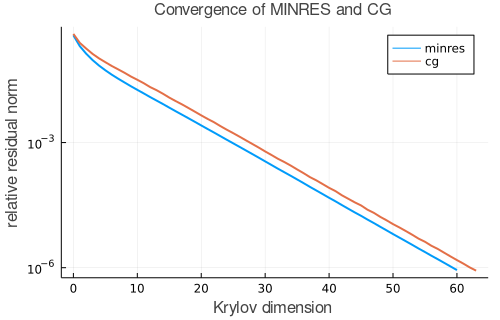

In [6]:
plt = plot(title="Convergence of MINRES and CG",
    xaxis=("Krylov dimension"),yaxis=(:log10,"relative residual norm"))
for method in [minres,cg]
    x̃,history = method(A,b,reltol=1e-6,maxiter=1000,log=true);
    relres = history[:resnorm] / norm(b)
    plot!(0:length(relres)-1,relres,label="$method")
    err = round( norm( x̃ - x ) / norm(x), sigdigits=4 )
    println("$method error: $err")
end
plt

There is little difference between the two methods here. Next, we increase the condition number of the matrix by a factor of 25. The rule of thumb predicts that the number of iterations required should increase by a factor of about 5.

In [7]:
A = FNC.sprandsym(n,density,1/2500)
b = A*x;

minres error: 0.0002484
cg error: 4.083e-5


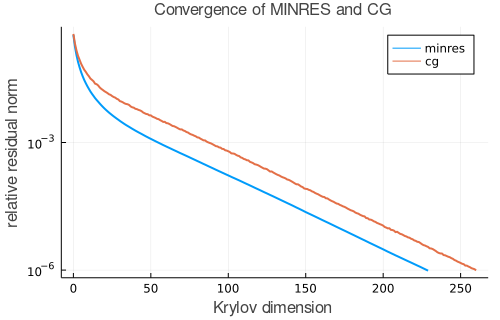

In [8]:
plt = plot(title="Convergence of MINRES and CG",
    xaxis=("Krylov dimension"),yaxis=(:log10,"relative residual norm"))
for method in [minres,cg]
    x̃,history = method(A,b,reltol=1e-6,maxiter=1000,log=true);
    relres = history[:resnorm] / norm(b)
    plot!(0:length(relres)-1,relres,label="$method")
    err = round( norm( x̃ - x ) / norm(x), sigdigits=4 )
    println("$method error: $err")
end
plt

Both methods have an early superlinear phase that allow them to finish slightly sooner than the factor of 5 predicted: {numref}`Theorem {number} <theorem-minrescg-converge>` is an upper bound, not necessarily an approximation. Both methods ultimately achieve the same reduction in the residual; MINRES stops earlier, but with a slightly larger error.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Exercises

1. ✍ For each part, the eigenvalues of $\mathbf{A}$ are given. Suppose MINRES is applied to solve $\mathbf{A}\mathbf{x}=\mathbf{b}$. Use {eq}`minres-conv` or {eq}`cgconv`, whichever is most appropriate, to determine a lower bound on $m$ to guarantee reduction of the residual norm by a factor $10^{-4}$. 

    **(a)** $-100,-99,\ldots,-1,1,2,\ldots,100$
    
    **(b)** $-100,1,2,\ldots,100$
    
    **(c)** $1,2,\ldots,100$

2. ⌨ Let $\mathbf{b}$ be a random unit vector of length 200. Define the matrix
   
    ```julia
    u = range(-200,-5,length=100); 
    v = range(10,100,length=100);
    A = diagm([u;v]);
    ```
    
    **(a)**  Apply 120 iterations of `minres` to solve $\mathbf{A}\mathbf{x}=\mathbf{b}$. Compute the relative error of the answer, and plot the norm of the residual as a function of $m$ on a log-linear scale.

    **(b)** Add to your graph the line representing the upper bound {eq}`minres-conv`. (Ignore the rounding in the exponent.) This line should stay strictly on or above the convergence curve.

3. ⌨ Let $\mathbf{b}$ be a random unit vector of length 500. Define the matrix
   
    ```julia
    A = spdiagm(range(4,10000,length=500));
    ```

    **(a)**  Apply 100 iterations of `minres` to solve $\mathbf{A}\mathbf{x}=\mathbf{b}$. Compute the relative norm of the answer. Plot the norm of the residual as a function of $m$.
    
    **(b)** Add to your graph the line representing the upper bound {eq}`cgconv`. This line should stay strictly on or above the convergence curve.
  
    **(c)** Add a convergence curve for 100 iterations of `cg`.

4. ✍ Suppose a family of SPD matrices $\mathbf{A}$ is parameterized by $t$, and that the condition numbers of the matrices scale like $O(t^2)$ as $t\to\infty$. Given that CG takes 60 iterations to reach a certain reduction in the error of a linear system when $t=200$, estimate the number of iterations CG will need to reach the same accuracy at $t=300$. 

5. ✍ Given real $n\times n$ symmetric $\mathbf{A}$ and vector $\mathbf{b}=\mathbf{A}\mathbf{x}$, we can define the scalar-valued function
  
    :::{math}
    \varphi(\mathbf{u}) = \mathbf{u}^T \mathbf{A} \mathbf{u} - 2 \mathbf{u}^T \mathbf{b}, \qquad \mathbf{u}\in\mathbb{R}^n.
    :::

    **(a)** Expand and simplify the expression $\varphi(\mathbf{x}+\mathbf{v})-\varphi(\mathbf{x})$, keeping in mind that $\mathbf{A}\mathbf{x}=\mathbf{b}$.
  
    **(b)** Using the result of part (a), prove that if $\mathbf{A}$ is an SPD matrix, $\varphi$ has a global minimum at $\mathbf{x}$.
  
    **(c)** Show that for any vector $\mathbf{u}$, $\|\mathbf{u}-\mathbf{x}\|_{\mathbf{A}}^2-\varphi(\mathbf{u})$ is constant.
  
    **(d)** Using the result of part (c), prove that CG minimizes $\varphi(\mathbf{u})$ over Krylov subspaces.

    ```{index} Helmholtz equation
    ```
    
6. ⌨ The following linear system arises from the Helmholtz equation for wave propagation:
    
    ```julia
    A = FNC.poisson(n) - k^2*I
    b = -ones(n^2)
    ```

    **(a)** Apply both MINRES and CG to the linear system for $n=50$ and $k=1.3$, solving to a relative residual tolerance of $10^{-5}$. Plotting their convergence curves together.
  
    **(b)** Repeat part (a) for $k=8$. 

    **(c)** Use `eigs` on the matrix from part (b) to show that it is indefinite. (Hint: Use `which=:SR` and `which=:LR` to get the smallest real and largest real values.) This helps explain why the CG convergence curve for this matrix looks rather strange.